In [2]:
# --- Libraries yang digunakan ---
import os
import pathlib
import random
import shutil
import zipfile

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
from google.colab import files, drive

# --- Mengimpor libraries untuk visualisasi ---
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# --- Mengimpor libraries untuk pemrosesan data gambar ---
from PIL import Image

# --- Mengabaikan peringatan ---
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Loading

In [3]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
# Path ke folder dataset di Google Drive
drive_path = '/content/drive/MyDrive/'
project_folder = 'parkinson'
dataset_path = os.path.join(drive_path, project_folder)
zip_file_name = 'parkinson_dataset.zip'
zip_file_path = os.path.join(dataset_path, zip_file_name)

# Direktori tujuan untuk mengesktrak isi zip (tetap di folder project)
extraction_path = dataset_path

print(f"Mencoba mengekstrak: '{zip_file_path}' ke '{extraction_path}'")

if os.path.exists(zip_file_path):
    !unzip '{zip_file_path}' -d '{extraction_path}'
    print(f"\nFile '{zip_file_name}' berhasil diesktrak ke: {extraction_path}")
else:
    print(f"File '{zip_file_name}' tidak ditemukan di: {zip_file_path}")

Mencoba mengekstrak: '/content/drive/MyDrive/parkinson/parkinson_dataset.zip' ke '/content/drive/MyDrive/parkinson'
Archive:  /content/drive/MyDrive/parkinson/parkinson_dataset.zip
   creating: /content/drive/MyDrive/parkinson/parkinson_dataset/
   creating: /content/drive/MyDrive/parkinson/parkinson_dataset/meander/
   creating: /content/drive/MyDrive/parkinson/parkinson_dataset/meander/healthy/
  inflating: /content/drive/MyDrive/parkinson/parkinson_dataset/meander/healthy/meander_healthy_001.jpg  
  inflating: /content/drive/MyDrive/parkinson/parkinson_dataset/meander/healthy/meander_healthy_002.jpg  
  inflating: /content/drive/MyDrive/parkinson/parkinson_dataset/meander/healthy/meander_healthy_003.jpg  
  inflating: /content/drive/MyDrive/parkinson/parkinson_dataset/meander/healthy/meander_healthy_004.jpg  
  inflating: /content/drive/MyDrive/parkinson/parkinson_dataset/meander/healthy/meander_healthy_005.jpg  
  inflating: /content/drive/MyDrive/parkinson/parkinson_dataset/meande

In [6]:
# Menghapus file zip setelah berhasil diesktrak
try:
  os.remove(zip_file_path)
  print(f"File '{zip_file_name} berhasil dihapus dari {dataset_path}")
except FileNotFoundError:
  print(f"File '{zip_file_name}' tidak ditemukan di: {dataset_path}")
except Exception as e:
  print(f"Terjadi kesalahan saat menghapus file: {e}")

print(f"Isi dari '{zip_file_name}' berhasil diekstrak ke: {extraction_path}")

File 'parkinson_dataset.zip berhasil dihapus dari /content/drive/MyDrive/parkinson
Isi dari 'parkinson_dataset.zip' berhasil diekstrak ke: /content/drive/MyDrive/parkinson


## Exploratory Data Analysis

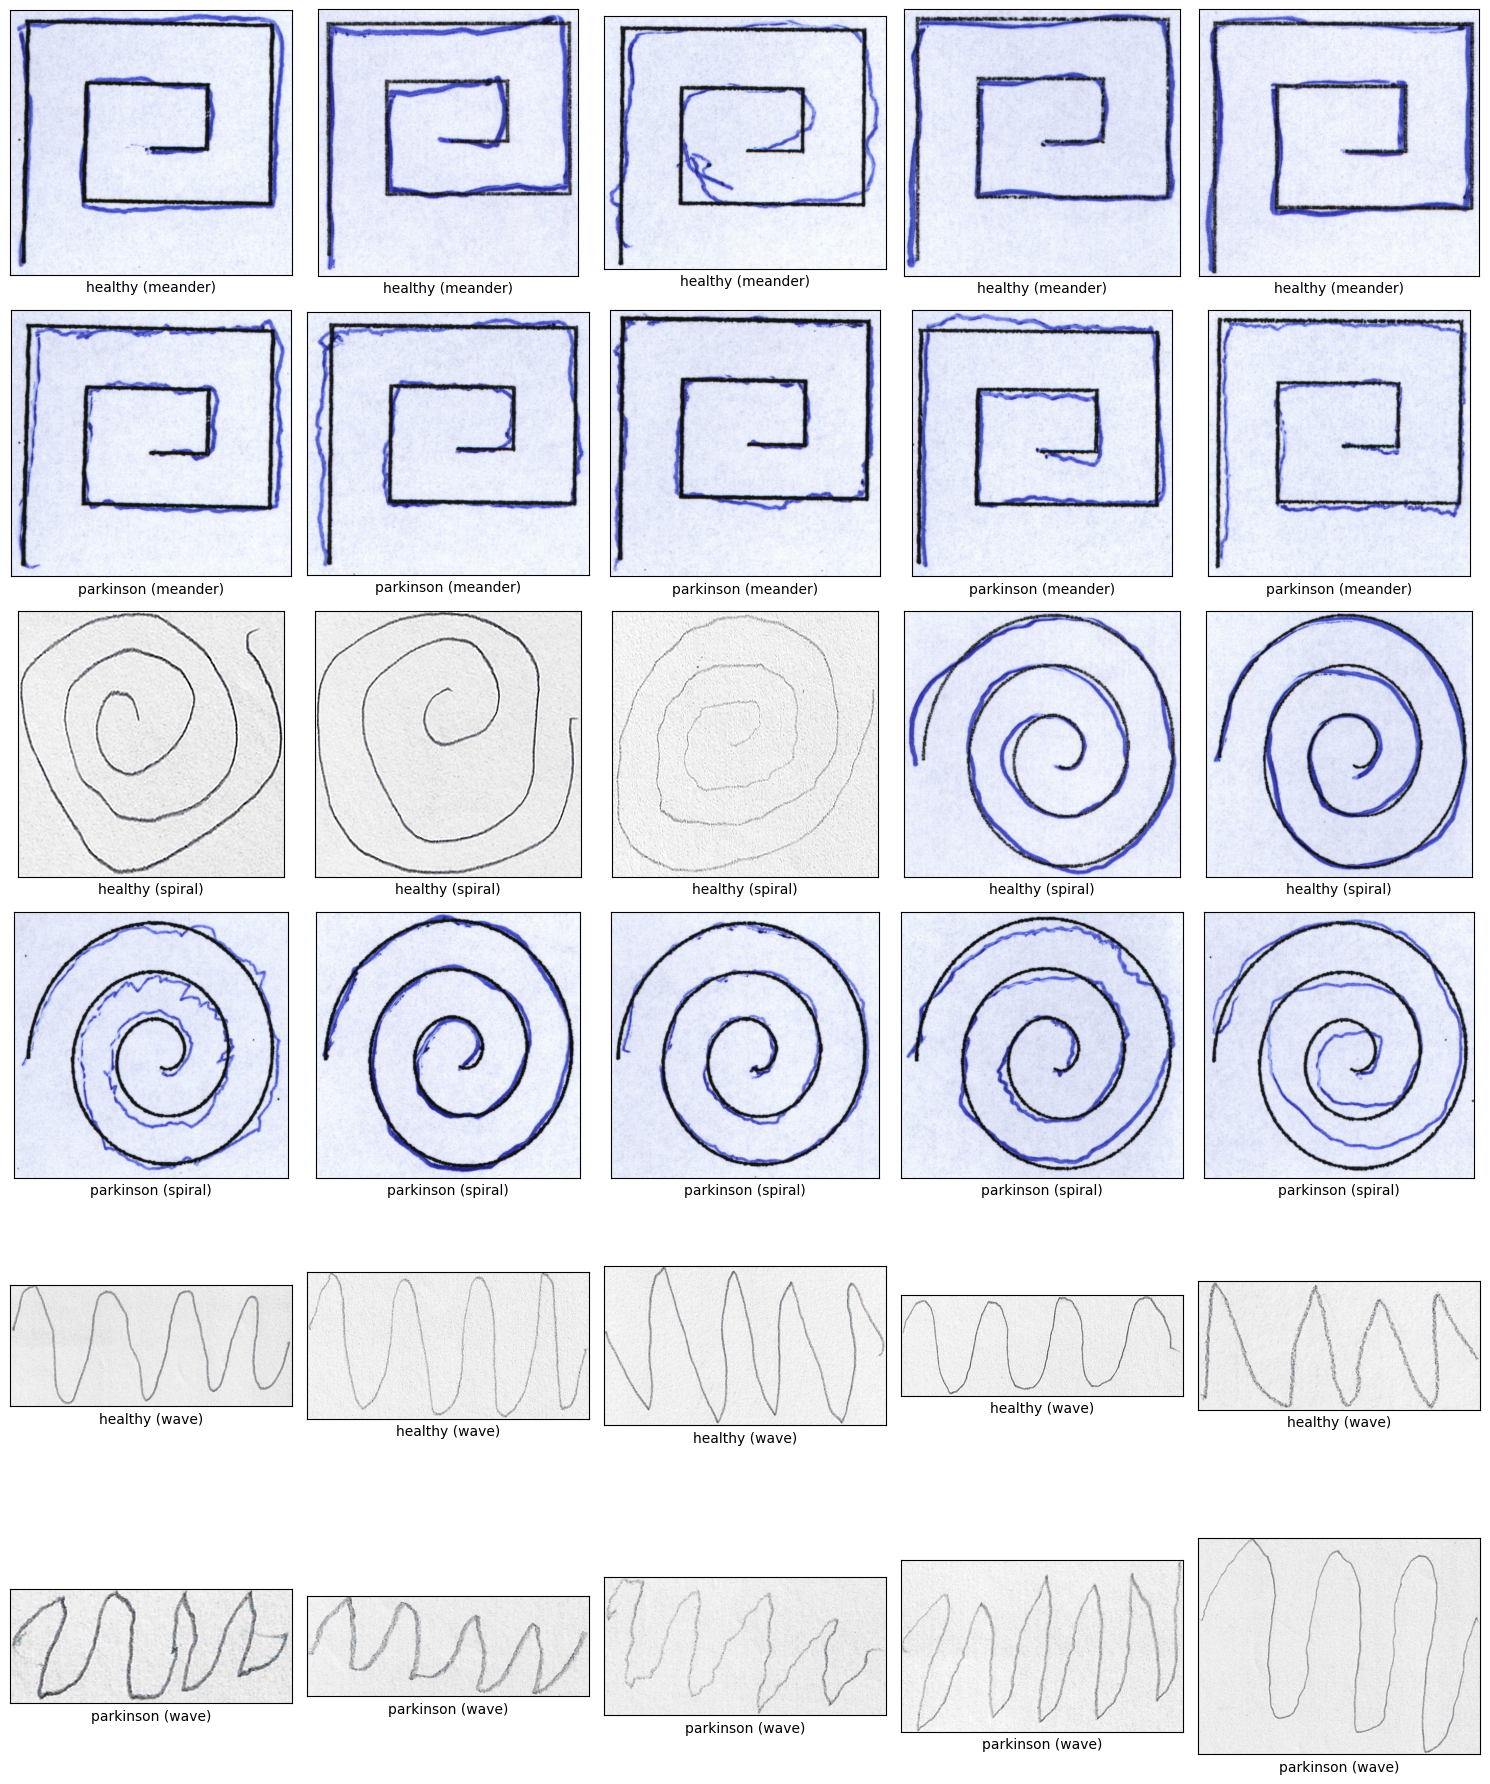

In [7]:
# Path ke direktori utama dataset
dataset_dir = '/content/drive/MyDrive/parkinson/parkinson_dataset/'
num_samples = 5  # Jumlah gambar yang ingin ditampilkan per kelas

sub_folders = ['meander', 'spiral', 'wave']
categories = ['healthy', 'parkinson']
all_data = {}

for sub_folder in sub_folders:
    for category in categories:
        folder_path = os.path.join(dataset_dir, sub_folder, category)
        if os.path.exists(folder_path) and os.path.isdir(folder_path):
            image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
            if image_files:
                key_name = f"{category} ({sub_folder})"
                all_data[key_name] = image_files
            else:
                print(f"Tidak ada gambar ditemukan di: {folder_path}")
        else:
            print(f"Folder tidak ditemukan: {folder_path}")

num_rows = len(all_data)
if num_rows > 0:
    fig, axs = plt.subplots(num_rows, num_samples, figsize=(15, 3 * num_rows))
    if num_rows == 1:
        axs = [axs]  # Handle kasus hanya satu baris

    for i, (class_name_with_folder, image_list) in enumerate(all_data.items()):
        images = np.random.choice(image_list, min(num_samples, len(image_list)), replace=False)
        class_name = class_name_with_folder.split(' ')[0]
        folder_name = class_name_with_folder.split('(')[1][:-1]
        for j, image_name in enumerate(images):
            img_path = os.path.join(dataset_dir, folder_name, class_name, image_name)
            try:
                img = Image.open(img_path).convert("RGB")
                axs[i, j].imshow(img)
                axs[i, j].set(xlabel=class_name_with_folder, xticks=[], yticks=[])
            except FileNotFoundError:
                print(f"File tidak ditemukan: {img_path}")
                axs[i, j].set_title("File Not Found")
            except Exception as e:
                print(f"Gagal membuka gambar: {img_path} - {e}")
                axs[i, j].set_title("Error")

    fig.tight_layout()
    plt.show()
else:
    print("Tidak ada data gambar yang ditemukan.")

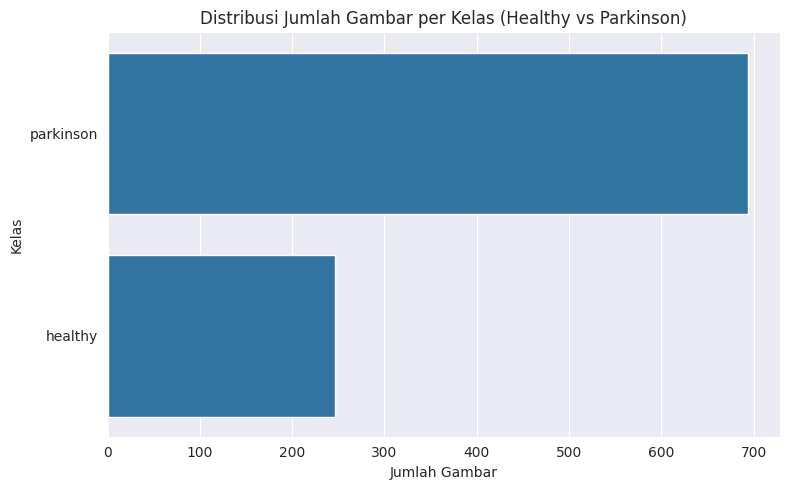


Jumlah Gambar per Kelas (Healthy vs Parkinson):
labels
parkinson    694
healthy      246
Name: count, dtype: int64


In [10]:
# Distribusi gambar di seluruh kelas
file_name = []
labels = []
full_path = []

# Mengumpulkan nama file, path lengkap, dan label dari setiap gambar
for path, subdirs, files in os.walk(dataset_dir):
    for name in files:
        if name.lower().endswith(('.png', '.jpg', '.jpeg')):  # Hanya memproses file gambar
            full_path.append(os.path.join(path, name))
            labels.append(path.split('/')[-1])
            file_name.append(name)

# Membuat DataFrame dari data yang terkumpul
distribution = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})

# Filter DataFrame hanya untuk label 'healthy' dan 'parkinson'
distribution_filtered = distribution[distribution['labels'].isin(['healthy', 'parkinson'])]

# Menghitung jumlah gambar per kelas
label_counts = distribution_filtered['labels'].value_counts().sort_values(ascending=False)

# Plot distribusi untuk kelas 'healthy' dan 'parkinson'
plt.figure(figsize=(8, 5))
sns.set_style("darkgrid")
sns.countplot(y='labels', data=distribution_filtered, order=label_counts.index)
plt.title('Distribusi Jumlah Gambar per Kelas (Healthy vs Parkinson)')
plt.xlabel('Jumlah Gambar')
plt.ylabel('Kelas')
plt.tight_layout()
plt.show()

print("\nJumlah Gambar per Kelas (Healthy vs Parkinson):")
print(label_counts)

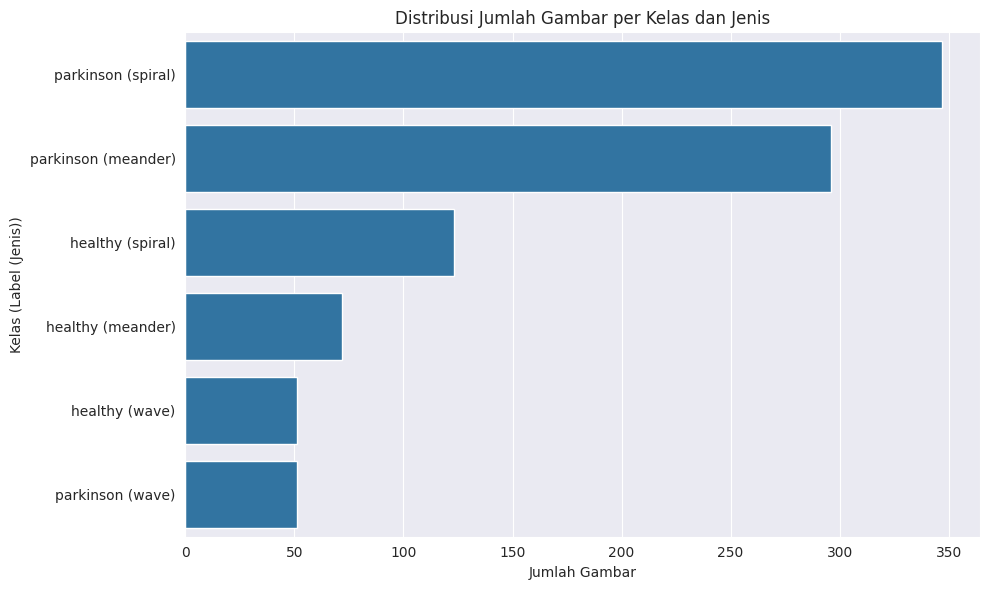


Jumlah Gambar per Kelas dan Jenis:
labels
parkinson (spiral)     347
parkinson (meander)    296
healthy (spiral)       123
healthy (meander)       72
healthy (wave)          51
parkinson (wave)        51
Name: count, dtype: int64


In [15]:
# Distribusi gambar per kelas dan jenisnya
full_path = []
combined_labels = []

# Mengumpulkan path dan label yang dikombinasikan
for path, subdirs, files in os.walk(dataset_dir):
    if path.endswith('healthy') or path.endswith('parkinson'):
        image_type = path.split('/')[-2]
        current_label = path.split('/')[-1]
        for name in files:
            if name.lower().endswith(('.png', '.jpg', '.jpeg')):
                full_path.append(os.path.join(path, name))
                combined_labels.append(f"{current_label} ({image_type})")

# Membuat DataFrame
distribution = pd.DataFrame({"path": full_path, "labels": combined_labels})

# Menghitung jumlah gambar per kelas dan jenis
label_counts = distribution['labels'].value_counts().sort_values(ascending=False)

# Plot distribusi
plt.figure(figsize=(10, 6))
sns.set_style("darkgrid")
sns.countplot(y='labels', data=distribution, order=label_counts.index)
plt.title('Distribusi Jumlah Gambar per Kelas dan Jenis')
plt.xlabel('Jumlah Gambar')
plt.ylabel('Kelas (Label (Jenis))')
plt.tight_layout()
plt.show()

print("\nJumlah Gambar per Kelas dan Jenis:")
print(label_counts)

### Distribusi Jumlah Gambar per Kelas dan Jenis

Visualisasi di atas menunjukkan distribusi jumlah gambar untuk setiap kombinasi kelas (healthy, parkinson) dan jenis gambar (meander, spiral, wave) dalam dataset.

**Observasi:**

* Kelas **parkinson** secara umum memiliki jumlah gambar yang lebih banyak dibandingkan kelas **healthy**.
* Jenis gambar **spiral** memiliki jumlah sampel terbanyak, terutama untuk kelas **parkinson**.
* Jenis gambar **wave** memiliki jumlah sampel yang paling sedikit untuk kedua kelas.
* Terlihat adanya ketidakseimbangan data antar kelas dan jenis. Misalnya, jumlah gambar **parkinson (spiral)** jauh lebih banyak dibandingkan **healthy (wave)** atau **parkinson (wave)**.

**Implikasi:**

Ketidakseimbangan distribusi ini dapat mempengaruhi kinerja model klasifikasi yang akan dilatih menggunakan dataset ini. Model berpotensi menjadi bias terhadap kelas dan jenis dengan jumlah sampel yang lebih banyak.

**Langkah Selanjutnya:**

Untuk mengatasi ketidakseimbangan ini, beberapa teknik dapat dipertimbangkan selama tahap *preprocessing* dan pelatihan model, seperti *oversampling* kelas minoritas, *undersampling* kelas mayoritas, atau penggunaan teknik augmentasi data.

In [11]:
# Melihat kombinasi jenis gambar dan label
image_sizes = {}

for sub_folder in sub_folders:
    for category in categories:
        folder_path = os.path.join(dataset_dir, sub_folder, category)
        if os.path.exists(folder_path) and os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(folder_path, filename)
                    try:
                        with Image.open(img_path) as img:
                            size = img.size
                            if (sub_folder, category) not in image_sizes:
                                image_sizes[(sub_folder, category)] = []
                            image_sizes[(sub_folder, category)].append(size)
                    except Exception as e:
                        print(f"Gagal membuka {img_path}: {e}")

for key, sizes in image_sizes.items():
    print(f"Ukuran gambar untuk {key}: {set(sizes)}")

Ukuran gambar untuk ('meander', 'healthy'): {(570, 570), (558, 544), (560, 541), (566, 566), (571, 556), (576, 540), (588, 566), (580, 562), (534, 540), (561, 530), (586, 544), (564, 520), (587, 552), (552, 524), (576, 552), (556, 528), (578, 552), (558, 522), (560, 528), (548, 526), (546, 538), (560, 534), (554, 530), (588, 556), (552, 532), (604, 546), (574, 560), (595, 601), (600, 530), (598, 572), (551, 528), (557, 568), (566, 580), (552, 526), (564, 528), (586, 558), (580, 576), (566, 522), (595, 564), (548, 516), (556, 582), (570, 550), (545, 557), (564, 540), (592, 556), (576, 560), (548, 522), (548, 528), (570, 568), (602, 542), (582, 542), (554, 584), (544, 555), (557, 552), (562, 536), (550, 513), (566, 570), (564, 576), (550, 522), (571, 563), (532, 547), (562, 554), (540, 566), (550, 540), (557, 521), (606, 542), (552, 534), (556, 547), (560, 538), (588, 554)}
Ukuran gambar untuk ('meander', 'parkinson'): {(604, 544), (570, 576), (632, 560), (604, 608), (571, 550), (560, 55

Pada tahapan ini, kita melihat jenis ukuran dan label dalam dataset. Jika setnya hanya berisi satu ukuran, berarti semua gambar dalam kategori tersebut memiliki ukuran yang sama.

Dari hasil di atas, diketahui:
- Untuk jenis gambar meander, ukuran gambar sangat bervariasi baik untuk kelas healthy maupun parkinson.
- Untuk jenis gambar spiral, ukurannya juga cukup bervariasi, meskipun terlihat ada kecenderungan ukuran yang lebih besar dibandingkan meander.
- Untuk jenis gambar wave, lebar gambar konsisten (512 piksel), tetapi tinggi gambar sangat bervariasi.

Dataset ini memiliki gambar dengan ukuran yang tidak seragam. Ini adalah informasi penting untuk langkah selanjutnya, seperti mempersiapkan data untuk model deep learning, di mana seringkali input dengan ukuran yang sama diperlukan. Kita mungkin perlu melakukan resizing atau cropping pada gambar.

In [2]:
pip install imagehash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 16.1 MB/s eta 0:00:00


In [3]:
import os
from PIL import Image
import imagehash
from collections import defaultdict

# Path ke direktori utama dataset
dataset_dir = '/content/drive/MyDrive/parkinson/parkinson_dataset/'
hashes = defaultdict(list)

for path, subdirs, files in os.walk(dataset_dir):
    for name in files:
        if name.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(path, name)
            try:
                with Image.open(img_path) as img:
                    hash_value = imagehash.phash(img)
                    hashes[hash_value].append(img_path)
            except Exception as e:
                print(f"Gagal memproses {img_path}: {e}")

duplicates = {hash_val: paths for hash_val, paths in hashes.items() if len(paths) > 1}

if duplicates:
    print("Gambar duplikat ditemukan:")
    for hash_val, paths in duplicates.items():
        print(f"Hash: {hash_val}")
        for path in paths:
            print(f"- {path}")
else:
    print("Tidak ada gambar duplikat ditemukan.")

Gambar duplikat ditemukan:
Hash: 8055a37a8f6b7a26
- /content/drive/MyDrive/parkinson/parkinson_dataset/meander/parkinson/meander_parkinson_040.jpg
- /content/drive/MyDrive/parkinson/parkinson_dataset/meander/parkinson/meander_parkinson_041.jpg


## Data Preprocessing

In [ ]:
target_size = (224, 224)

for path, subdirs, files in os.walk(dataset_dir):
    for name in files:
        if name.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(path, name)
            try:
                img = Image.open(img_path)
                img_resized = img.resize(target_size)
                img_resized.save(img_path)  # Menimpa file asli dengan gambar yang di-resize
                print(f"Berhasil mengubah ukuran: {img_path} menjadi {target_size}")
            except Exception as e:
                print(f"Gagal mengubah ukuran {img_path}: {e}")

print("Proses mengubah ukuran gambar selesai.")